In [1]:
# import libraries
import numpy as np
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import CustomJS, Slider, Range1d, Span, Toggle, Spinner, LinearAxis
from bokeh.layouts import column, row, gridplot
output_notebook()

Loading BokehJS ...

In [2]:
# style definitions
colors = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

def set_fig_style(fig,xmax,ymax,xlab="x",ylab="y(x,t)",xmin=0,ymin=None):
    if ymin is None:
        ymin = -ymax
    for (ax, lab) in [(fig.xaxis,xlab),(fig.yaxis,ylab)]:
        ax.axis_label = lab
        ax.axis_label_text_font_size = '14pt'
        ax.axis_label_text_font_style = 'normal'
        ax.major_label_text_font_size = '12pt'
    fig.x_range = Range1d(xmin,xmax)
    fig.y_range = Range1d(ymin,ymax)

In [3]:
def make_wave_animation(ks,cs,ωs=None,disprel=None,xmax=200,show_modes=False,dt=None,xres=40,do_show=True):
    ks = np.asarray(ks)
    cs = np.asarray(cs)
    assert ks.ndim == 1
    assert cs.shape == ks.shape
    acs = abs(cs)
    phis = np.angle(cs)

    if ωs is not None:
        assert disprel is None
    else:
        ωs = disprel(ks)
    assert ωs.shape == ks.shape

    # resolution: take xres points per shortest wavelength in the packet
    # dx = λmin / xres = 2π/kmax / xres
    dx = 2*np.pi/(xres*abs(ks).max())
    x = np.arange(0,xmax,dx)
    
    if dt is None:
        dt = 1.
        
    if isinstance(dt,(int,float)):
        dt = (dt/10,dt*10,dt/10,dt)
    else:
        assert len(dt) == 4
    
    source = ColumnDataSource(data=dict(x=x,y=0*x))
    for ik,(k,ac,phi) in enumerate(zip(ks,acs,phis)):
        source.data['y'] += (yi := ac*np.cos(k*x+phi))
        if show_modes:
            source.data[f'y{ik}'] = yi

    fig = figure(width=900,height=500)
    fig.line('x', 'y', source=source, line_width=4, color=colors[0])
    if show_modes:
        for ik,k in enumerate(ks):
            fig.line('x', f'y{ik}', source=source, line_width=2, line_alpha=0.5,
                     color=colors[1 + (ik%(len(colors)-1))])

    set_fig_style(fig,xmax,ymax=1.03*abs(source.data['y']).max())

    slider_t = Slider(start=0, end=1000, value=0, step=0.1, title='t', sizing_mode="stretch_both")
    spinner_dt = Spinner(low=dt[0], high=dt[1], step=dt[2], value=dt[3], title="δt", width=80, sizing_mode="stretch_height")

    # JavaScript callback to do animations directly in the browser (without needing to communicate with server)
    cb_sliders = CustomJS(args=dict(source=source, slider_t=slider_t, pars=np.array([ks,ωs,acs,phis]).T, show_modes=show_modes),
                          code="""const t = slider_t.value;
                                  const xs = source.data['x'];
                                  const ys = source.data['y'];                                  
                                  const fpw = (x,[k,ω,ac,ϕ]) => ac * Math.cos(k*x - ω*t + ϕ);
                                  if (show_modes) { var yks = pars.map((_,ik) => source.data[`y${ik}`]) };
                                  xs.forEach((x,i) => {
                                      // yₖ(xᵢ,t) = |cₖ| cos(kₖ x - ωₖ t + ϕₖ)
                                      // y(xᵢ,t) = sumₖ yₖ(xᵢ,t)
                                      ys[i] = pars.reduce((y,pp,ik) => {
                                                  const ym = fpw(x,pp);
                                                  if (show_modes) yks[ik][i] = ym;
                                                  return y + ym; }, 0.)
                                  });
                                  source.change.emit();""")
    slider_t.js_on_change('value', cb_sliders)

    # Set up Play/Pause button/toggle JS
    cb_toggle = CustomJS(args=dict(s_t=slider_t,s_dt=spinner_dt,fig=fig),
                         code="""function upfun() { s_t.value += s_dt.value; cb_obj.active || clearInterval(updater) }
                                 cb_obj.label = cb_obj.active ? '❚❚ Pause' : '► Play';
                                 if (cb_obj.active) var updater = setInterval(upfun, 20);""")
    toggle = Toggle(label='► Play',active=False, sizing_mode="stretch_height", width=80)
    toggle.js_on_change('active', cb_toggle)

    layout = column(row(toggle, spinner_dt, slider_t), fig)
    if do_show:
        show(layout)
    return (fig,layout)

# Hoja 4, ejercicio 5
## Enunciado
Una cuerda infinita está sometida a la acción de una fuerza externa de forma que las ondas resultantes satisfacen la ecuación:
\begin{equation}
    \frac{1}{v^2} \frac{\partial^2 g(x,t)}{\partial t^2} = \frac{\partial^2 g(x,t)}{\partial x^2} + F \cos\left( \omega t \right)
\end{equation}
donde $F$ y $\omega$ son constantes. (a) Suponiendo que la solución es de la
forma $g(x,t) = y(x) \cos\omega t$ con $y(0)=0$ y $y'(0)=0$, hallar el valor de
$y(x)$. (b) Lo mismo con la suposición $y(0)=0$ y $y(\ell)=0$, donde $\ell$ es
constante.

## Solución
Insertando $g(x,t) = y(x) \cos\omega t$ en la ecuación y quitando un factor común de $\cos\omega t$ llegamos a
\begin{equation}
    \frac{-\omega^2}{v^2} y(x) = \frac{\partial^2 y(x)}{\partial x^2} + F,
\end{equation}
que es equivalente a la ecuación de un oscilador armónico sometido a una fuerza
constante, donde la posición $x$ juega el papel que normalmente tiene el tiempo
$t$. Definiendo $k = \omega/v$, la solución general (homogénea + partícular) tiene la forma
\begin{equation}
    y(x) = A \cos kx + B \sin kx - \frac{F}{k^2}
\end{equation}
donde el termino constante $-F/k^2$ es una solución particular.

(a) Para $y(0) = y'(0) = 0$, obtenemos $A = F/k^2$ y $B=0$, y entonces la solución
\begin{equation}
    y(x) = \frac{F}{k^2} (\cos kx - 1).
\end{equation}

(b) De $y(0) = 0$, obtenemos $A = F/k^2$. De $y(\ell) = 0$ obtenemos
\begin{equation}
    \frac{F}{k^2} (\cos k\ell - 1) + B \sin k\ell = 0,
\end{equation}
con solución general $B = \frac{F}{k^2} \frac{1-\cos k\ell}{\sin k\ell} =
\frac{F}{k^2} \tan(k\ell/2)$. Como curiosidad, se puede notar que para $k\ell =
2n \pi$, con $n \in \mathbb{Z}$, la condición se cumple independiente del
valor de $B$ (lo que significa que $B$ **no** está definido por las
condiciones de contorno y queda libre), mientras que para $k\ell = (2n+1) \pi$,
la ecuación **nunca** se cumple (sale $-2=0$), es decir, que no hay
coeficientes $A$ y $B$ que resuelven la ecuación, y las condiciones de contorno
no son compatibles con la forma de solución que hemos asumido.

# Hoja 5, ejercico 4: Modos de un laser & peine de luz
## Enunciado
Un modelo simple de un laser es una cavidad unidimensional óptica de longitud $L$ que contiene un medio
activo (p.ej., un cristal de titanio-zafiro, Ti:sapphire). Usamos que las
ecuaciones que describen la propagación de luz (las ecuaciones de Maxwell) en el
medio se pueden escribir como ecuación de ondas para el campo eléctrico $E(x,t)$
con velocidad de propagación de $c/n$, donde $n$ es el indice de refracción del
medio. (a) Calcular las frecuencias normales de la cavidad, asumiendo que los
espejos actúan como paredes rígidas para las ondas luminosas (es decir, que
$E(x\!=\!0,t)=E(L\!=\!x,t)=0$). (b) Suponer que el cristal de Ti:sapphire tiene
indice de refracción $n=1.77$ y emite luz centrada en la frecuencia angular
$\omega_0 = 2.36\cdot10^{15}~\mathrm{s}^{-1}$ (correspondiente a longitud de onda en el
vacio de $\lambda = 2\pi c/\omega_0 \approx 798~$nm), con una distribución
gaussiana con desviación estándar de $\sigma = 2.5\cdot 10^{14}~\mathrm{s}^{-1}$. Cuál
es el mayor valor de $L$ para que sólo será excitado un modo normal de la
cavidad en el intervalo $\omega_0 \pm 3\sigma$? (c) Asumiendo que la longitud de
la cavidad es $L=10~\mu$m, ¿cuantos modos están excitados en el intervalo dado?
(d) Asumiendo que la amplitud de cada modo normal está dado por $c_n =
e^{-\frac{(\omega_n - \omega_0)^2}{2\sigma^2}}$, representar gráficamente el
campo eléctrico (en unidades arbitrarias) en el centro de la cavidad,
$E(x=\frac{L}{2}, t)$ como función de $t$ en el intervalo $t = [0,200]~$fs
($1~$fs = $10^{-15}~$s), e interpretarlo. Para obtener la representación
gráfica, se recomienda el uso de MATLAB o algo equivalente, con la suma sobre
$n$ hecho numéricamente hasta un $n_{\max}$ suficientemente alto (p.ej.,
$\omega_{n_{\max}} > \omega_0 + 5 \sigma$).

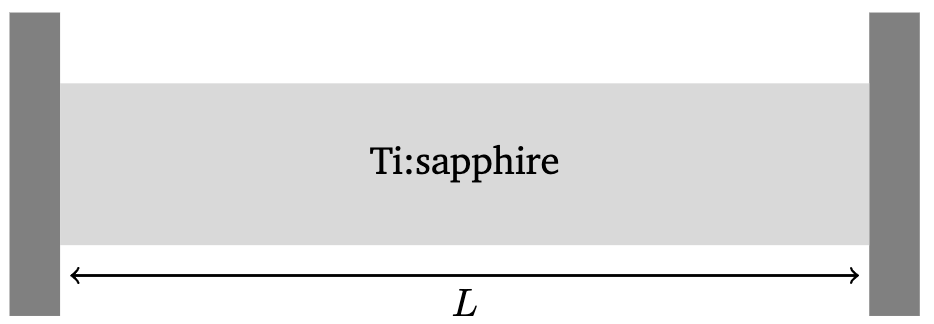

## Solución
(a) Tenemos $k_m = \frac{m \pi}{L}$, y $\omega_m = v k_m = \frac{m \pi
c}{n L}$. (Cuidado que aquí $n$ es el indice de refracción, así que usamos $m$
para el indice del modo.)

(b) El rango buscado es $[\omega_0-3\sigma,\omega_0+3\sigma] = [1.61,3.11] \cdot
10^{15}~$s$^{-1}$. Para que la diferencia $\delta\omega = \frac{\pi c}{n L}$
entre modos sea más grande que $3\sigma$, necesitamos que $L < \frac{\pi c}{3 n
\sigma} = 0.709~\mu$m. En este caso, las frecuencias de modos $m = 2,3,4$ son
$\omega_{2,3,4} = (1.5,2.25,3.0)\cdot10^{15}~$s$^{-1}$, así que modos 3 y 4
están dentro del rango buscado. Para que realmente haya solo un modo, se tiene
que reducir $L$ hasta que modo 4 sale del rango buscado, es decir $\omega_4 =
\omega_0+3\sigma$, lo que corresponde a $L = 0.684~\mu$m, y frecuencias de modos
de $\omega_{2,3,4} = (1.56,2.33,3.11) \cdot 10^{15}~$s$^{-1}$, así que solo
modo 3 está dentro del rango buscado.

(c) Para $L=10~\mu$m, los modos en el rango buscado cumplen tanto
$\omega_m > \omega_0 - 3\sigma$ como $\omega_m < \omega_0 + 3\sigma$, lo que 
corresponde a $m > 30.3$ y $m < 58.4$. Entonces modos $m=31$ hasta $m=58$ están
dentro del rango buscado, lo que corresponde a $28$ modos excitados dentro del
rango dado.

(d) El campo eléctrico está dado por $E(x,t) = \sum_m c_m \sin(k_m x) \cos(\omega_m t)$, 
para $x=L/2$ y usando los parámetros dados, obtenemos la figura abajo.
Vemos que el campo corresponde a una serie (un "tren") de pulsos ultracortos (de
una duración de $\approx 8~$fs) repetidos periódicamente, con periodo de $\approx 60~$fs.
Debajo enseñamos una animación del campo en la cavidad, donde se ve que se trata realmente
de un único paquete Gaussiano que propaga entre los espejos y pasa periodicamente por el centro. En un laser real, uno de los espejos es semi-transparente y en cada periodo, una fracción del paquete de ondas está emitido. La distribución en frecuencia (=transformada de Fourier) de esta secuencia periódica de pulsos ultracortos corresponde a una serie de picos estrechos equiespaciados en frecuencia, un llamado "frequency comb" (peine de luz). Estos fuentes de luz se usan tanto para metrología de precisión por su gran resolución en frecuencia, como para la investigación de efectos ultrarrápidos que se pueden resolver en tiempo a causar de la duración corta de los pulsos (cmp. [Femtochemistry](https://en.wikipedia.org/wiki/Femtochemistry) y [Attosecond physics](https://en.wikipedia.org/wiki/Attosecond_physics)).

In [4]:
# plot frequency comb
# usamos unidades de micrometros (1 μm = 1e-6 m) y femtosegundos (1 fs = 1e-15 s).
# Los valores de los constantes y variables en estos unidades son:
n = 1.77
ω0 = 2.36
σ = 0.25
L = 10.
c = 0.299792458
ms = np.arange(20,70)
km = ms*np.pi/L
ωm = c/n * km
cm = np.exp(-(ωm-ω0)**2/(2*σ**2))

# plot frequency distribution
fig = figure(width=900,height=300,title="Distribución de frecuencias")
set_fig_style(fig,xmin=ωm[0]-0.05,xmax=ωm[-1]+0.05,ymin=0,ymax=1.05,xlab="ω (fs⁻¹)", ylab="cₘ")
fig.vbar(ωm,0.01,cm)
show(fig)

# plot field at x=L/2 for t=0,200 fs
ts = np.linspace(0,200,3001)
Et = np.sum(cm*np.sin(km*L/2)*np.cos(ωm*ts[:,None]), axis=1)
fig = figure(width=900,height=300,title="Campo eléctrico")
set_fig_style(fig,xmax=ts[-1],ymax=Et.max()*1.01,xlab="t (fs)", ylab="E(x=L/2, t) (arb.u.)")
fig.line(ts,Et,color=colors[0],line_width=2)
show(fig)

# the above is for a sine-wave normal mode basis, we use plane waves (exponentials) in the general function (make_wave_animation)
# -> use that sin(k x) = (exp(ikx) - exp(-ikx))/2i
km_exp = np.r_[-km,km]
ωm_exp = np.r_[ωm,ωm]
cm_exp = np.r_[-cm,cm] / 2j
fig,layout = make_wave_animation(km_exp,cm_exp,ωm_exp,xmax=L+1e-10,show_modes=False,dt=0.2,do_show=False)
fig.xaxis.axis_label = "x (μm)"
fig.yaxis.axis_label = "E(x,t) (arb.u.)"
show(layout)

# Hoja 5, ejercicio 5: Chirped pulse amplification - amplificación de pulso gorjeado
## Enunciado
Una limitación en conseguir pulsos de láseres muy intensos es el daño causado en$\renewcommand{\Re}{\operatorname{Re}}$
el medio de amplificación si la amplitud del campo es demasiado grande. Para
evitar esta limitación, se usa el concepto de *chirped pulse amplification*
(CPA, premio nobel 2018). Esta técnica consiste en "estirar" temporalmente un
pulso mediante propagación por un medio dispersivo y así bajar la amplitud
máxima, amplificar el pulso alargado, y después "recomprimir" el pulso
amplificado para obtener un pulso ultracorto y muy intenso. Estudiamos algunos
aspectos de este proceso. Tratamos un pulso Gaussiano ultracorto de luz descrito
(en $x=0$) por $E(t) = \Re \mathcal{E}(t)$, con $\mathcal{E}(t) = E_0
e^{-\frac{t^2}{2\sigma^2}} e^{i \omega_0 t}$, con amplitud máxima $E_0$,
frecuencia central $\omega_0$, y duración $\sigma$. (a) Calcular la distribución
de frecuencias del pulso, dada por la transformada de Fourier
$\tilde{\mathcal{E}}(\omega) =
\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \mathcal{E}(t) e^{-i \omega t}
\mathrm{d}t$. Discutir la forma de $\tilde{\mathcal{E}}(\omega)$ y la relación
entre $\sigma$ y la anchura de la distribución de frecuencias. (b) El pulso se
propaga por un medio dispersivo donde cada frecuencia acumula una fase diferente
(sin cambiar la energía total o la distribución de energía) de tal manera que
después del medio, la transformada de Fourier está dado por
$\tilde{\mathcal{E}}_2(\omega) = e^{i \frac{g}{2} (\omega-\omega_0)^2}
\tilde{\mathcal{E}}(\omega)$, con $g$ una constante real (con unidades de
tiempo$^2$). Usando la transformación inversa de Fourier, $\mathcal{E}_2(t) =
\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \tilde{\mathcal{E}}_2(\omega) e^{i \omega t}
\mathrm{d}\omega$, obtener la forma temporal del pulso después de la
propagación, $E_2(t) = \Re \mathcal{E}_2(t)$, y verificar que se puede escribir
como un pulso *gorjeado* en cual la frecuencia varia con el tiempo,
\begin{equation}
    E_2(t) = E_g e^{-\frac{t^2}{2\sigma_g^2}} \cos(\phi(t))
\end{equation}
con $\sigma_g = \sqrt{\sigma^2 + g^2/\sigma^2}$, $E_g = E_0
\sqrt{\frac{\sigma}{\sigma_g}}$, y $\phi(t) = \omega_0 t - \frac12 \frac{g
t^2}{\sigma^2\sigma_g^2} - \frac12\arg{z}$, donde $z=\sigma^2-ig =
|z|e^{i\arg{z}}$. Analizar los cambios de amplitud, duración, y oscilación, en
particular la frecuencia instantánea $\omega(t) =
\frac{\mathrm{d}\phi(t)}{\mathrm{d}t}$ y discutir su dependencia con $g$. (c) El
pulso gorjeado $E_2(t)$ pasa por un amplificador, y después se propaga por un
medio que deshace el "gorjeo" y le convierte a la forma original. Asumiendo que
se quiere conseguir un pulso con amplitud $E_0 = 10^{13}~$V/m (aproximadamente
veinte veces más fuerte que el campo eléctrico que siente el electrón en un
átomo de hidrógeno en el estado $n=1$) y duración $\sigma = 10~$fs
($1~\text{fs}=10^{-15}~$s), calcular el valor de $g$ necesario y la duración
$\sigma_g$ asociada para que la amplitud del pulso gorjeado no supera $E_g =
10^7~$V/m (lo que asumimos como el límite para evitar daños en el medio de
amplificación).

## Solución
(a) Evaluando la transformada de Fourier, obtenemos
\begin{equation}
    \tilde{\mathcal{E}}(\omega) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \mathcal{E}(t) e^{-i \omega t} \mathrm{d}t
     = \sigma E_0 e^{-\frac{1}{2} \sigma^2 (\omega - \omega_0)^2} = \sigma E_0 e^{-\frac{1}{2 \sigma^{-2}} (\omega - \omega_0)^2},
\end{equation}
lo que significa que la distribución de frecuencias de un pulso Gaussiano
también es Gaussiano, centrado en la frecuencia $\omega_0$ y con anchura
(desviación estándar) de $\sigma^{-1}$. Es decir, si aumentamos la duración
$\sigma$ del pulso, su frecuencia está mejor definido, y si bajamos su duración
para que sea mejor definida el momento en que llega, aumentamos el rango de
frecuencias que contribuyen al pulso. Es otro ejemplo del principio de
incertidumbre, en este caso entre tiempo y frecuencia.

(b) Para obtener la transformada inversa de Fourier,
\begin{equation}
    \mathcal{E}_2(t) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \tilde{\mathcal{E}}_2(\omega) e^{i \omega t} \mathrm{d}\omega,
\end{equation}
escribimos
\begin{align}
    \tilde{\mathcal{E}}_2(\omega) = \sigma E_0 e^{i \frac{g}{2} (\omega-\omega_0)^2} e^{-\frac{1}{2} \sigma^2 (\omega - \omega_0)^2}
    = \sigma E_0 e^{-\frac{1}{2} (\sigma^2 - i g) (\omega - \omega_0)^2} = \sigma E_0 e^{-\frac{1}{2} z (\omega - \omega_0)^2},
\end{align}
con $z = \sigma^2 - i g$ como en el enunciado. La transformada inversa de
Fourier de esta función (que existe para $\Re z > 0$) es
\begin{equation}
    \mathcal{E}_2(t) = E_0 \frac{\sigma}{\sqrt{z}}  e^{-\frac{t^2}{2 z} + i \omega_0 t}.
\end{equation}
Ahora usamos que $\frac{1}{z} = \frac{z^*}{|z|^2} = \frac{\sigma^2 + ig}{\sigma^4 + g^2} =
\frac{1}{\sigma_g^2} + i \frac{g}{\sigma^2 \sigma_g^2}$, y que $\sqrt{z} = \sqrt{|z|}
e^{\frac{i}{2}\arg z} = \sqrt{\sigma \sigma_g} e^{\frac{i}{2}\arg z}$, con
$\sigma_g = \sqrt{\sigma^2 + g^2/\sigma^2}$ como dado. Insertando y reorganizando, obtenemos
\begin{equation}
    \mathcal{E}_2(t) = E_0 \sqrt{\frac{\sigma}{\sigma_g}} e^{-\frac{t^2}{2 \sigma_g^2}} 
    e^{i \left(\omega_0 t + \frac{g t^2}{2 \sigma^2 \sigma_g^2} - \frac12 \arg z\right)},
\end{equation}
y se ve directamente que $E_2(t) = \Re \mathcal{E}_2(t)$ tiene la forma dado en
el enunciado. Vemos que el pulso tiene todavía una forma Gaussiana, pero con una
duración aumentada de $\sigma_g = \sqrt{\sigma^2 + g^2/\sigma^2}$, y con una
amplitud máxima más baja, $E_g = E_0 \sqrt{\sigma/\sigma_g}$, lo que corresponde
a una supresión de la intensidad maxima $(\propto E_g^2)$ por un factor $\sigma_g/\sigma
= \sqrt{1 + g^2/\sigma^4}$. La oscilación del pulso ahora no solo contiene un
factor $\omega_0 t$, sino también un factor cuadrático en $t$, lo que significa
que la frecuencia cambia a lo largo del pulso. En particular, la frecuencia
instantánea está dada por $\frac{\mathrm{d}\phi(t)}{\mathrm{d}t} = \omega_0 -
\frac{g}{\sigma^2 \sigma_g^2} t = \omega_0 + \Delta\omega(t)$. Se ve que
para $g>0$ la frecuencia instantánea baja durante el pulso (las frecuencias
altas llegan antes), y para $g<0$, la frecuencia sube durante el pulso
(las frecuencias bajas llegan antes).

Como ilustración, representamos abajo pulsos gorjeados para el caso de un
pulso originalmente ultracorto con $\omega = 2\cdot 10^{15}~$s$^{-1}$ (longitud de ondas
$\lambda = \frac{2\pi}{k} = \frac{2\pi c_0}{\omega} \approx 942~$nm), $\sigma =
3~$fs, y un gorjeo que se puede ajustar entre $g = -100~\mathrm{fs}^2$ y $g = 100~\mathrm{fs}^2$.
Vemos que aumentando $|g|$, el pulso se hace más largo en el tiempo, menos intenso, y
la frecuencia instantanea cambia durante el pulso (las oscilaciones son más lentas al
final que al principio para $g>0$, y al revés para $g<0$). Se puede comentar que
este efecto es visualmente muy obvio porque hemos escogido un pulso ultracorto que
contiene un espectro amplio de frecuencias. Recordamos que el pulso tiene
siempre el mismo espectro de frecuencias, $|\tilde{\mathcal{E}}(\omega)| =
|\tilde{\mathcal{E}}_2(\omega)|$ (pintado en negro a la derecha), la única diferencia es la **fase** 
$\arg(\tilde{\mathcal{E}}(\omega))$ de la transformada de Fourier (pintado en amarillo). Entonces, 
en el caso de usar un pulso original más largo ($\sigma$ más grande) en cual la
distribución de frecuencias es más estrecho, la frecuencia instantánea en el pulso
gorjeado también se mantiene cerca del valor medio y el gorjeo no es tan obvio.

(c) Obtenemos que $\sigma_g = \sigma E_0^2 / E_g^2$, que para los parámetros
dados corresponde a $\sigma_g = 10~$ms (es decir, se tiene que alargar el pulso
por un factor $10^{12}$). El valor requerido de 
$g = \pm \sigma \sqrt{\sigma_g^2 - \sigma^2}$ es
$g = \pm 10^{-16}~\mathrm{s}^2 = \pm 10^{14}~\mathrm{fs}^2$ (no importa su signo).

In [5]:
# plot chirped pulses
def make_chirp_plot(ts,ωs,ω0,σ,gmax):
    Et = np.exp(-ts**2/(2*σ**2))*np.cos(ω0*ts)
    Eω = σ*np.exp(-σ**2/2*(ωs-ω0)**2)

    source_t = ColumnDataSource(data=dict(t=ts,E=Et,Δω=0*Et))
    source_ω = ColumnDataSource(data=dict(ω=ωs,aE=Eω,φ=0*Eω))

    fig_t = figure(width=450,height=400)
    fig_ω = figure(width=450,height=400)
    set_fig_style(fig_t,xmin=ts[0],xmax=ts[-1], ymax=1.05,
                  xlab='t (fs)',ylab=r'E(t) (arb.u.)')
    set_fig_style(fig_ω,xmin=ωs[0],xmax=ωs[-1], ymax=1.05*Eω.max(),
                  xlab='ω (fs⁻¹)',ylab='Ẽ(ω) (arb.u.)')
    
    fig_t.line(x='t',y='E',source=source_t, line_width=2, color=colors[0], legend_label="E(t)")
    fig_t.line(x='t',y='Δω',source=source_t, line_width=2, color=colors[1], legend_label="Δω(t) (fs⁻¹)")
    fig_ω.line(x='ω',y='aE',source=source_ω, line_width=2, color=colors[0], legend_label="|Ẽ(ω)|")
    fig_ω.line(x='ω',y='φ', source=source_ω, line_width=2, color=colors[1], legend_label="arg(Ẽ(ω))/π")
    
    slider_g = Slider(start=-gmax, end=gmax, value=0, step=0.1, title='g', sizing_mode="stretch_both")

    # JavaScript callback to do animations directly in the browser (without needing to communicate with server)
    cb_g = CustomJS(args=dict(slider_g=slider_g, source_t=source_t, source_ω=source_ω, ω0=ω0,σ=σ),
                    code="""const g = slider_g.value;
                            const ts = source_t.data['t'];
                            const Ets = source_t.data['E'];
                            const Δωs = source_t.data['Δω'];
                            const ωs = source_ω.data['ω'];
                            const φs = source_ω.data['φ'];
                            const σg = Math.sqrt(σ**2+g**2/σ**2);
                            const Eg = Math.sqrt(σ/σg);
                            const φ0 = -0.5*Math.atan2(-g,σ**2);
                            const cω = -g/(2*σ**2*σg**2);
                            ts.forEach((t,i) => {
                                Ets[i] = Eg*Math.exp(-0.5*(t/σg)**2)*Math.cos(φ0+ω0*t+cω*t**2);
                                Δωs[i] = 2*cω*t;
                            });
                            ωs.forEach((ω,i) => { φs[i] = g*(ω-ω0)**2 / (2*Math.PI); });
                            source_t.change.emit();
                            source_ω.change.emit();""")
    slider_g.js_on_change('value', cb_g)

    layout = column(slider_g,row(fig_t,fig_ω))
    show(layout)

ω0 = 2.
σ = 3.
ts = np.linspace(-60,60,4001)
ωs = np.linspace(0,4,501)
make_chirp_plot(ts,ωs,ω0,σ,gmax=100)